In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
%matplotlib inline
import os
import sys
from functools import partial

import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import skimage.color as sk_color
import skimage.morphology as sk_morph
import scipy.io

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

sys.path.append('../moco-v3/')
import suppix_utils.datasets_seeds as datasets

sys.path.append('../')
import cast_models.cast

c:\Users\28272\anaconda3\envs\cast\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Prepare utility functions for visualization

In [3]:
def generate_contour(label, size=2, is_symmetric=True):
    if is_symmetric:
        label = np.pad(label, ((1, 1), (1, 1)), mode='symmetric')
    else:
        label = np.pad(label, ((1, 1), (1, 1)), mode='constant', constant_values=0)
    l_diff = label[1:-1, 1:-1] != label[1:-1, :-2]
    r_diff = label[1:-1, 1:-1] != label[1:-1, 2:]
    t_diff = label[1:-1, 1:-1] != label[:-2, 1:-1]
    b_diff = label[1:-1, 1:-1] != label[2:, 1:-1]

    edge = (l_diff + r_diff + t_diff + b_diff).astype(label.dtype)

    # dilation
    if size > 0:
        disk = sk_morph.disk(size)
        edge = edge.astype(np.int32)
        edge = sk_morph.dilation(edge, disk).astype(label.dtype)
    return edge

def label2color(label, img):
    out = sk_color.label2rgb(label, img, kind='avg', bg_label=-1)
    edge = generate_contour(label, 0).astype(bool)
    out[edge] = 1
    return out

### Load color mappings for visualization

In [4]:
CMAP = scipy.io.loadmat('colormapvoc.mat')['colormapvoc']
CMAP = (CMAP * 255).astype(np.uint8)

### Define models and load pre-trained weights

In [5]:
MODEL_CLASS_NAME = 'cast_base'
CHECKPOINT_PATH = '../model_weights/CAST-B/checkpoint_0099.pth.tar'

model = cast_models.cast.__dict__[MODEL_CLASS_NAME]().cuda()
ckpt = torch.load(CHECKPOINT_PATH, map_location='cuda:0')
state_dict = {k[len('module.base_encoder.'):]: v for k, v in ckpt['state_dict'].items()
              if 'module.base_encoder.' in k and 'head' not in k}
msg = model.load_state_dict(state_dict, strict=False)
print(msg)
model = model.eval()

c:\Users\28272\anaconda3\envs\cast\lib\site-packages\torch\functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4316.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


_IncompatibleKeys(missing_keys=['head.weight', 'head.bias'], unexpected_keys=[])


### Prepare dataloader for loading ImageNet images

In [6]:
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225])

augmentation = [
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
]

train_dataset = datasets.ImageFolder(
    'demo_images',
    transforms.Compose(augmentation),
    normalize=normalize,
    n_segments=196,
    compactness=10.0,
    blur_ops=None,
    scale_factor=1.0)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=1, shuffle=False, drop_last=False)

KeyError: 'level5'

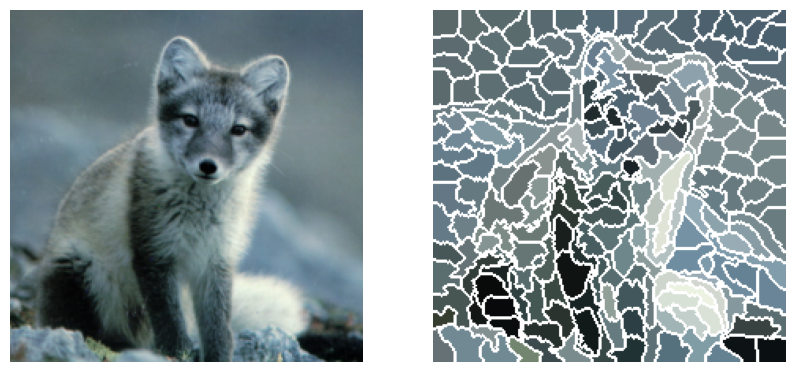

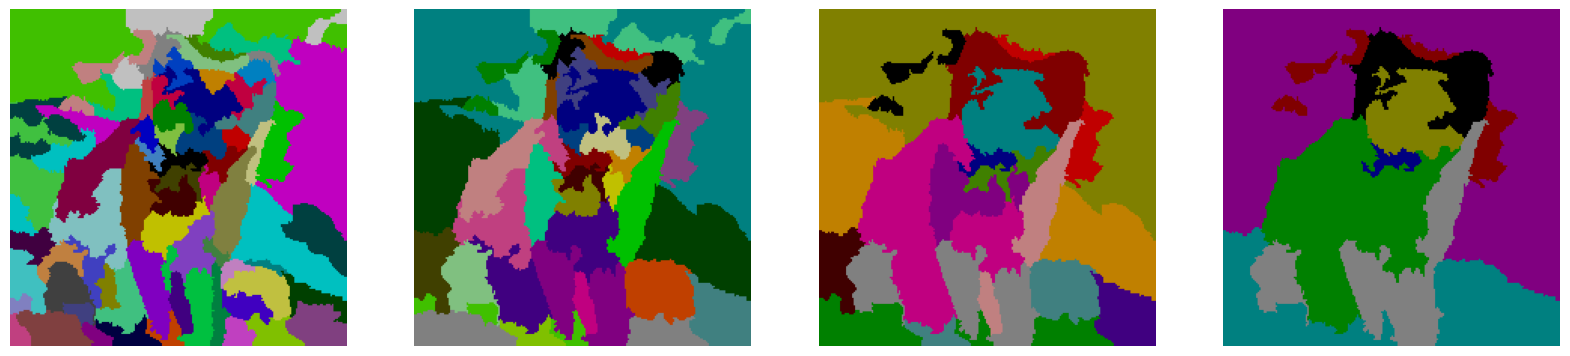

In [ ]:
for i, (img, suppixel, label) in enumerate(train_loader):
    img = img.cuda() # input images
    suppixel = suppixel.cuda() # superpixels

    # Forward pass to return intermediate groupings
    intermediates = model.forward_features(img, suppixel)

    # Aggregate groupings from fine to coarse levels
    segmentations = {}
    prev_labels = {}
    # Iterate through the finest to the coarsest scales
    for level in [1, 2, 3, 4]:
        # Iterate through the mini-batch
        for b in range(img.shape[0]):
            # Grouping logit for the current level
            logit = intermediates['logit{:d}'.format(level)][b]
            label = torch.argmax(logit, dim=-1)

            # Gather coarser grouping at the current level
            # The level-1 grouping index for each level-0 group is [1, 2, 2, 0, 1, 1, 0]
            # The level-2 grouping index for each level-1 group is [0, 1, 0]
            # We infer the level-2 grouping for each level-0 group as [1, 0, 0, 0, 1, 1, 0]
            if level > 1:
                prev_label = prev_labels['level{:d}'.format(level-1)][b]
                label = torch.gather(label, 0, prev_label.view(-1))
            if prev_labels.get('level{:d}'.format(level), None) is None:
                prev_labels['level{:d}'.format(level)] = []
            prev_labels['level{:d}'.format(level)].append(label)

            # Gather groupings for each superpixel
            label = torch.gather(label, 0, suppixel[b].view(-1))
            label = label.view(suppixel.shape[-2:])
            if segmentations.get('level{:d}'.format(level), None) is None:
                segmentations['level{:d}'.format(level)] = []
            segmentations['level{:d}'.format(level)].append(label)
        segmentations['level{:d}'.format(level)] = torch.stack(segmentations['level{:d}'.format(level)], dim=0)
        segmentations['level{:d}'.format(level)] = segmentations['level{:d}'.format(level)].cpu().data.numpy()

    # We only visualize the first image in the batch
    img = img[0].cpu().data.numpy()
    suppixel = suppixel[0].cpu().data.numpy()
    img = img * np.array([0.229, 0.224, 0.225])[:, None, None]
    img = img + np.array([0.485, 0.456, 0.406])[:, None, None]

    # Resize superpixel to the image resolution.
    suppixel = cv2.resize(suppixel, (224, 224), interpolation=cv2.INTER_NEAREST)
    suppixel = label2color(suppixel, img.transpose(1, 2, 0))

    f, ax = plt.subplots(1, 2, figsize=(10, 5));
    ax[0].axis('off'); ax[0].imshow(img.transpose(1, 2, 0))
    ax[1].axis('off'); ax[1].imshow(suppixel)

    f, ax = plt.subplots(1, 4, figsize=(20, 5));
    # f, ax = plt.subplots(1, 5, figsize=(25, 5));
    for level in [1, 2, 3, 4]:
        seg = segmentations['level{:d}'.format(level)][0]
        seg = cv2.resize(seg,
                         (224, 224),
                         interpolation=cv2.INTER_NEAREST)
        ax[level-1].axis('off'); ax[level-1].imshow(CMAP[seg])

    # Only iterate once
    if i > 0:
        break